In [63]:
import cv2
import numpy as np
import matplotlib
import matplotlib.pyplot as plt
from sklearn.cluster import KMeans, DBSCAN, AffinityPropagation, MeanShift, estimate_bandwidth
from scipy.spatial.distance import pdist, squareform
from scipy.stats import iqr
import os

In [125]:
img_id = '20_nir_2009-07-23'
# ind = 3
label = 'yes'

# filein = '../data/fields_raw_' + label + '_good/' + img_id + '.png'

label_out = 1 if label=='yes' else 0

# directory = '../data/fields_raw_' + label + '/'
# directory = '../data/fields_raw_' + label + '_cropped/'
directory = '../data/fields_raw_' + label + '_new/'
# directory = '../data/fields_raw_' + label + '_temp/'

filein = directory + img_id + '.png'
# filein = directory + os.listdir(directory)[ind]


In [126]:
filein

'../data/fields_raw_yes_new/20_nir_2009-07-23.png'

In [127]:
# Load raw image, convert to grayscale
img = cv2.imread(filein)
gray_raw = cv2.cvtColor(img,cv2.COLOR_BGR2GRAY)

In [129]:
# rows

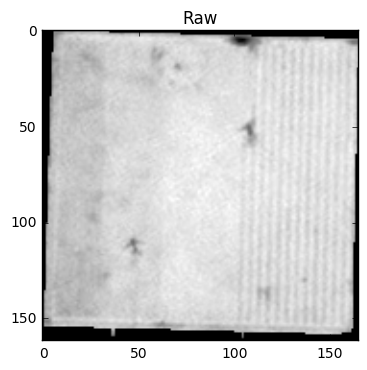

In [130]:
plt.imshow(gray_raw,cmap=matplotlib.cm.get_cmap('gray'))
plt.title('Raw')
plt.show()

In [131]:
# Normalized
edge = 0
b, t = np.nanpercentile(gray_raw, [edge, 100 - edge])
gray_norm = 255*(gray_raw - b) / (t - b)

In [132]:
# Crop
length = gray_raw.shape[0]
width = gray_raw.shape[1]

frac = 0.05
x1 = int(frac*length)
x2 = length - int(frac*length)
y1 = int(frac*width)
y2 = width - int(frac*width)

cropped = gray_raw[x1:x2,y1:y2]

gray_raw = cropped

In [133]:
# 2d fft

F = np.fft.fft2(gray_raw)

In [134]:
# plt.imshow(np.log10(np.abs(F)))
# plt.show()

In [135]:
# Saturate scale based on percentiles
gray_nonzr = np.ravel(gray_raw[np.where(gray_raw!=np.min(gray_raw))])
gray_vec = np.ravel(gray_nonzr)

edge = 5  # percent
b, t = np.percentile(gray_vec, [edge, 100 - edge])

gray_sat = gray_raw.copy()
gray_sat[np.where(gray_sat<b)] = b
gray_sat[np.where(gray_sat>t)] = t

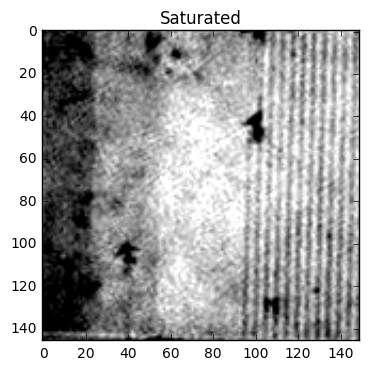

In [136]:
plt.imshow(gray_sat,cmap=matplotlib.cm.get_cmap('gray'))
plt.title('Saturated')
plt.show()

In [137]:
import pywt

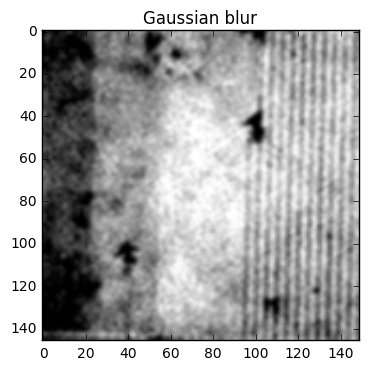

In [165]:
# Gaussian blur
blur = cv2.GaussianBlur(gray_sat,(3,3),0)
plt.imshow(blur,cmap=matplotlib.cm.get_cmap('gray'))
plt.title('Gaussian blur')
plt.show()

In [139]:
cA, cD = pywt.dwt(blur,'db1')

In [142]:
import scipy.misc
scipy.misc.imsave('test.jpg', cA)

src = cv2.imread('test.jpg');

gray_cD = cv2.cvtColor(src,cv2.COLOR_BGR2GRAY)

edges = cv2.Canny(gray_cD,100,150,apertureSize = 5)


In [166]:
# Adaptive thresholding on saturated + Gaussian blur
thr_ad_blur = cv2.adaptiveThreshold(blur,255,cv2.ADAPTIVE_THRESH_MEAN_C,cv2.THRESH_BINARY,5,0)
# thr_ad_blur = cv2.adaptiveThreshold(gray_cD,255,cv2.ADAPTIVE_THRESH_MEAN_C,cv2.THRESH_BINARY,5,0)

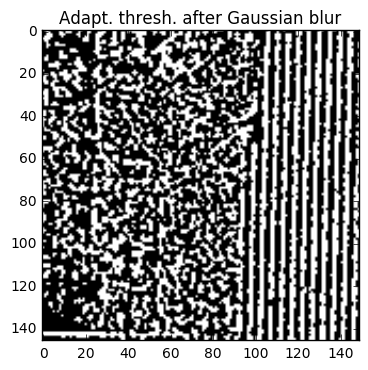

In [167]:
plt.imshow(thr_ad_blur,cmap=matplotlib.cm.get_cmap('gray'))
plt.title('Adapt. thresh. after Gaussian blur')
plt.show()

In [168]:
vertical = thr_ad_blur.copy()
horizontal = thr_ad_blur.copy()

In [169]:
# horizontalsize = horizontal.shape[1]/3
ver_structure = cv2.getStructuringElement(cv2.MORPH_RECT,(5,1))
hor_structure = cv2.getStructuringElement(cv2.MORPH_RECT,(1,5))

In [201]:
ver_erosion = cv2.erode(vertical,ver_structure,iterations = 1)
hor_erosion = cv2.erode(horizontal,hor_structure,iterations = 1)
# dilation = cv2.dilate(erosion,structure,iterations=1)
# erode(horizontal, horizontal, horizontalStructure, Point(-1, -1));
# plt.imshow(ver_erosion)
# plt.show()

In [171]:
# from pyimagesearch.localbinarypatterns import LocalBinaryPatterns
from skimage.feature import local_binary_pattern

In [172]:
radius = 1
n_points = 8 * radius
lbp = local_binary_pattern(gray_sat, n_points, radius, 'uniform')


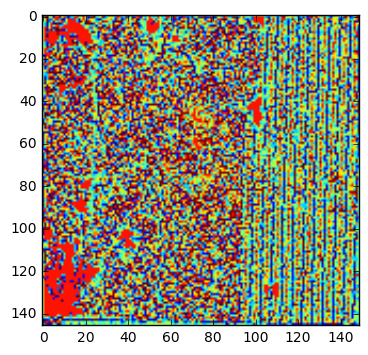

In [173]:
plt.imshow(lbp)
plt.show()

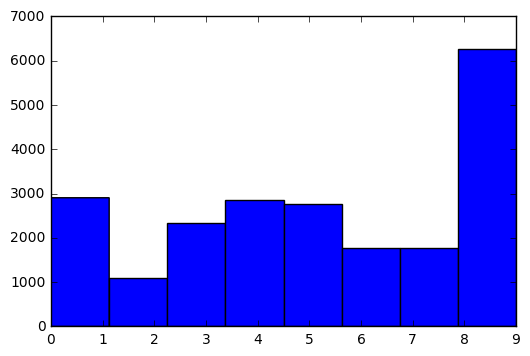

In [174]:
plt.hist(lbp.ravel(),bins=n_points)
plt.show()

In [175]:
# Calculate length of diagonal
diag = np.sqrt(thr_ad_blur.shape[0]**2+thr_ad_blur.shape[1]**2)
diag

208.60728654579637

In [176]:
# Probabilistic Hough transform (detects line segments)

minLineLength = 20
maxLineGap = 1
lines_pr = cv2.HoughLinesP(thr_ad_blur,1,np.pi/180,10,minLineLength,maxLineGap)
# lines_pr = cv2.HoughLinesP(gray_cD,1,np.pi/180,10,minLineLength,maxLineGap)
# lines_pr = cv2.HoughLinesP(edges,1,np.pi/180,10,minLineLength,maxLineGap)
len(lines_pr)

1700

In [177]:
# Get angles and lengths
thetas_pr = []
lengths_pr = []
for line in lines_pr.squeeze():
    x1 = line[0]
    y1 = line[1]
    x2 = line[2]
    y2 = line[3]
    theta = np.arctan2(y2-y1,x2-x1)*180/ np.pi
    thetas_pr.append(theta)
    length = np.sqrt((x1-x2)**2 + (y1-y2)**2)
    lengths_pr.append(length)
thetas_pr = np.array(thetas_pr)
lengths_pr = np.array(lengths_pr)
# lengths_pr = np.array(lengths_pr)/diag


In [178]:
# feature for detecting if image contains patterns at all: 
# spread in angle in line segments with similar length
thetas_pr_rad = thetas_pr
thetas_pr = np.abs(thetas_pr)


In [179]:
# k-means clustering

# TRY BOTH FEATURES, OTHER CLUSTERING ALGOS, OR THRESHOLD TO BE LEARNED

# feat = np.array([thetas_pr,lengths_pr]).T
feat = np.array([lengths_pr]).T
# feat = np.array([lengths_pr]).T/diag
kmeans = KMeans(n_clusters=2).fit(feat)
labels = kmeans.labels_



# db = DBSCAN(eps=0.5, min_samples=5).fit(feat)
# core_samples_mask = np.zeros_like(db.labels_, dtype=bool)
# core_samples_mask[db.core_sample_indices_] = True
# labels = db.labels_

# bandwidth = estimate_bandwidth(feat, quantile=0.2, n_samples=10)
# ms = MeanShift(bandwidth=bandwidth, bin_seeding=True)
# ms.fit(feat)
# labels = ms.labels_
# cluster_centers = ms.cluster_centers_

# labels_unique = np.unique(labels)
# n_clusters_ = len(labels_unique)

# print("number of estimated clusters : %d" % n_clusters_)

In [180]:
# unique_labels = set(labels)
# colors = plt.cm.Spectral(np.linspace(0, 1, len(unique_labels)))

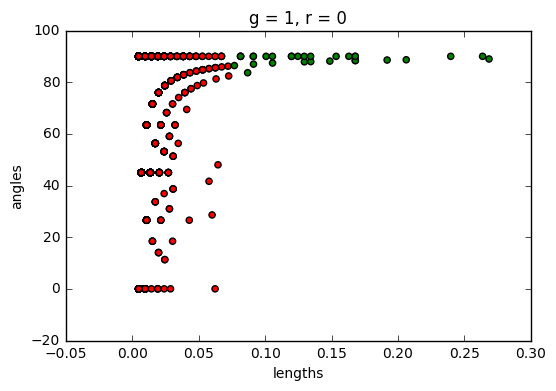

In [181]:
colors = ['g' if label else 'r' for label in labels]
lengths = lengths_pr/diag
plt.scatter(lengths,thetas_pr,c=colors)
plt.xlabel('lengths')
plt.ylabel('angles')
plt.title('g = 1, r = 0')

plt.show()

In [182]:
print iqr(np.intersect1d(thetas_pr[lengths>=0.],thetas_pr[lengths<0.025]))
print iqr(np.intersect1d(thetas_pr[lengths>=0.025],thetas_pr[lengths<0.05]))
print iqr(np.intersect1d(thetas_pr[lengths>=0.05],thetas_pr[lengths<0.075]))
print iqr(np.intersect1d(thetas_pr[lengths>=0.075],thetas_pr[lengths<0.1]))
print iqr(thetas_pr[lengths>=0.1])

45.0
31.443776786
29.5766815501
2.00770808959
1.58545682725


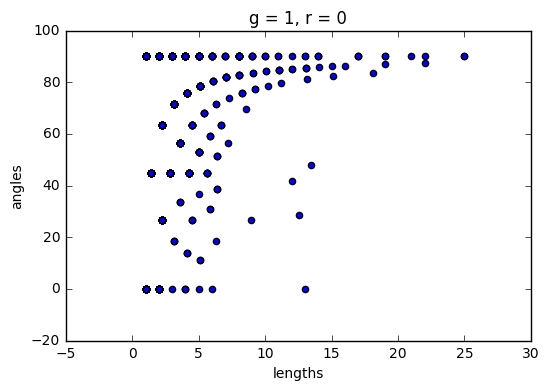

In [184]:
# Remove top 1% of lines based on length

top = np.percentile(lengths_pr,99)
top_lengths = lengths_pr[lengths_pr>top]
top_ix = np.where(lengths_pr>top)[0]
bot_ix = np.where(lengths_pr<=top)[0]

colors = ['g' if label else 'r' for label in labels]
plt.scatter(lengths_pr[bot_ix],thetas_pr[bot_ix])
plt.xlabel('lengths')
plt.ylabel('angles')
plt.title('g = 1, r = 0')

plt.show()

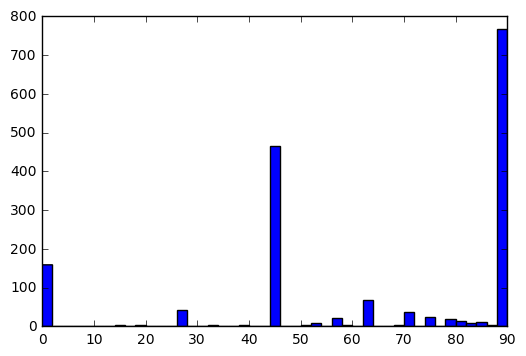

In [185]:
plt.hist(thetas_pr[bot_ix],45)
plt.show()

In [186]:
from scipy.stats import skew

In [187]:
# print np.abs(skew(thetas_pr[bot_ix]))

In [188]:
# # Look at top 50% of lines
# top = np.percentile(lengths_pr,50)
# top_lengths = lengths_pr[lengths_pr>top]
# top_ix = np.where(lengths_pr>top)[0]
# bot_ix = np.where(lengths_pr<=top)[0]

In [189]:
# # colors = ['g' if label else 'r' for label in labels]
# plt.scatter(lengths_pr[top_ix],thetas_pr[top_ix],c='g')
# plt.scatter(lengths_pr[bot_ix],thetas_pr[bot_ix],c='r')
# plt.xlabel('lengths')
# plt.ylabel('angles')
# plt.title('g = 1, r = 0')

# plt.show()

In [190]:
# plt.hist(thetas_pr[top_ix],3)
# plt.show()

In [191]:
# plt.hist(thetas_pr[bot_ix],3)
# plt.show()

In [192]:
# measure of uniformity vs one or two bins being much larger than the rest

# test for negative examples too, look at the top 1% of them

In [193]:
top10 = np.percentile(lengths_pr,99)
print top10

iqrangle_top10 = iqr(thetas_pr[lengths_pr>=top10])

print iqrangle_top10

25.01
1.63657704162


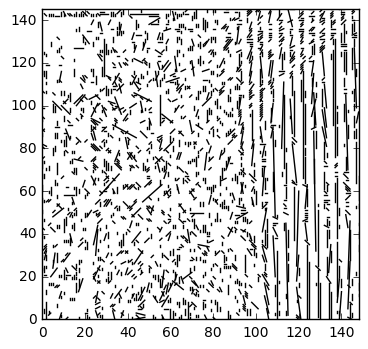

In [210]:
for line_idx in range(len(lines_pr)):
    line = lines_pr[line_idx][0]
    plt.plot([line[0],line[2]],[line[1],line[3]],c='k')
plt.axis('image')
plt.show()

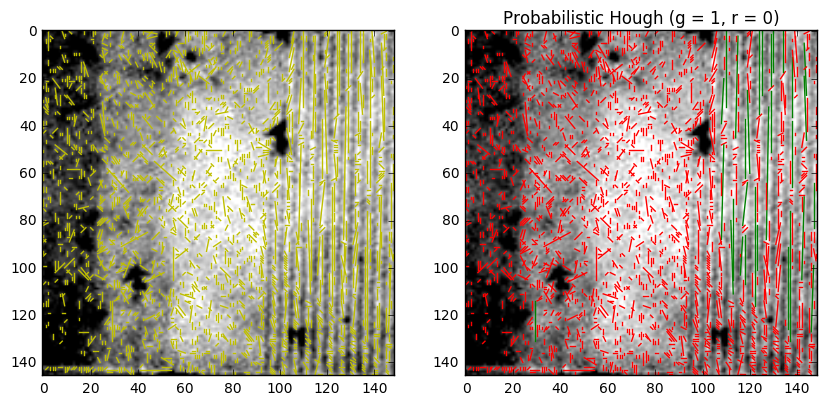

In [211]:
plt.figure(figsize=(10,20))

plt.subplot(121)
plt.imshow(gray_sat,cmap=matplotlib.cm.get_cmap('gray'))
ylim = plt.gca().get_ylim()
xlim = plt.gca().get_xlim()
for line_idx in range(len(lines_pr)):
    line = lines_pr[line_idx][0]
    plt.plot([line[0],line[2]],[line[1],line[3]],c='y')
plt.gca().set_ylim(ylim)
plt.gca().set_xlim(xlim)

plt.subplot(122)
plt.imshow(gray_sat,cmap=matplotlib.cm.get_cmap('gray'))
ylim = plt.gca().get_ylim()
xlim = plt.gca().get_xlim()
plt.title('Probabilistic Hough (g = 1, r = 0)')
for line_idx in range(len(lines_pr)):
    line = lines_pr[line_idx][0]
    plt.plot([line[0],line[2]],[line[1],line[3]],c=colors[line_idx])
plt.gca().set_ylim(ylim)
plt.gca().set_xlim(xlim)
plt.show()

In [195]:
np.max(lengths_pr)

56.008927859761783

In [196]:
lengths_pr[lengths_pr==np.max(lengths_pr)]

array([ 56.00892786])

In [197]:
# find cluster id that has the max length
good = labels[lengths_pr==np.max(lengths_pr)][0]
bad = 1 if good==0 else 0
print good, bad

1 0


In [198]:
ix  = np.where(labels==good)
ix_bad = np.where(labels==bad)
cluster_size = len(labels[ix])

In [199]:
# skewness of angles

print np.abs(skew(thetas_pr[ix]))
print np.abs(skew(thetas_pr[ix_bad]))
print np.abs(skew(thetas_pr))

1.89168783799
0.788351127401
0.814264272177


In [122]:

avglength  = np.mean(lengths_pr[ix])

stdangle  = np.std(thetas_pr[ix])

medlength =  np.median(lengths_pr[ix])

iqrangle  = iqr(thetas_pr[ix])

print (cluster_size,avglength,medlength,stdangle,iqrangle)
# print (cluster_size,medlength,iqrangle,iqrangle_top10)
# print (cluster_size,medlength/diag,iqrangle)
    


(35, 47.094477750133919, 40.01249804748511, 1.1020848884221066, 1.325485709647972)


In [124]:
avglength  = np.mean(lengths_pr)

stdangle  = np.std(thetas_pr)

medlength =  np.median(lengths_pr)

iqrangle  = iqr(thetas_pr)

print (cluster_size,avglength,medlength,stdangle,iqrangle)


(35, 5.7684888062125772, 3.0, 12.758435110643385, 0.0)
